In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold

import torch
import torch.nn as nn

import cv2

%matplotlib inline

pd.options.display.max_rows = 10000
#pd.options.display.max_columns = None
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 100

In [2]:
HEIGHT = 137
WIDTH = 236
IMG_SIZE = 128

TRAIN = ['../input/train_image_data_0.parquet',
         '../input/train_image_data_1.parquet',
         '../input/train_image_data_2.parquet',
         '../input/train_image_data_3.parquet']

In [3]:
df = pd.read_parquet(TRAIN[0])

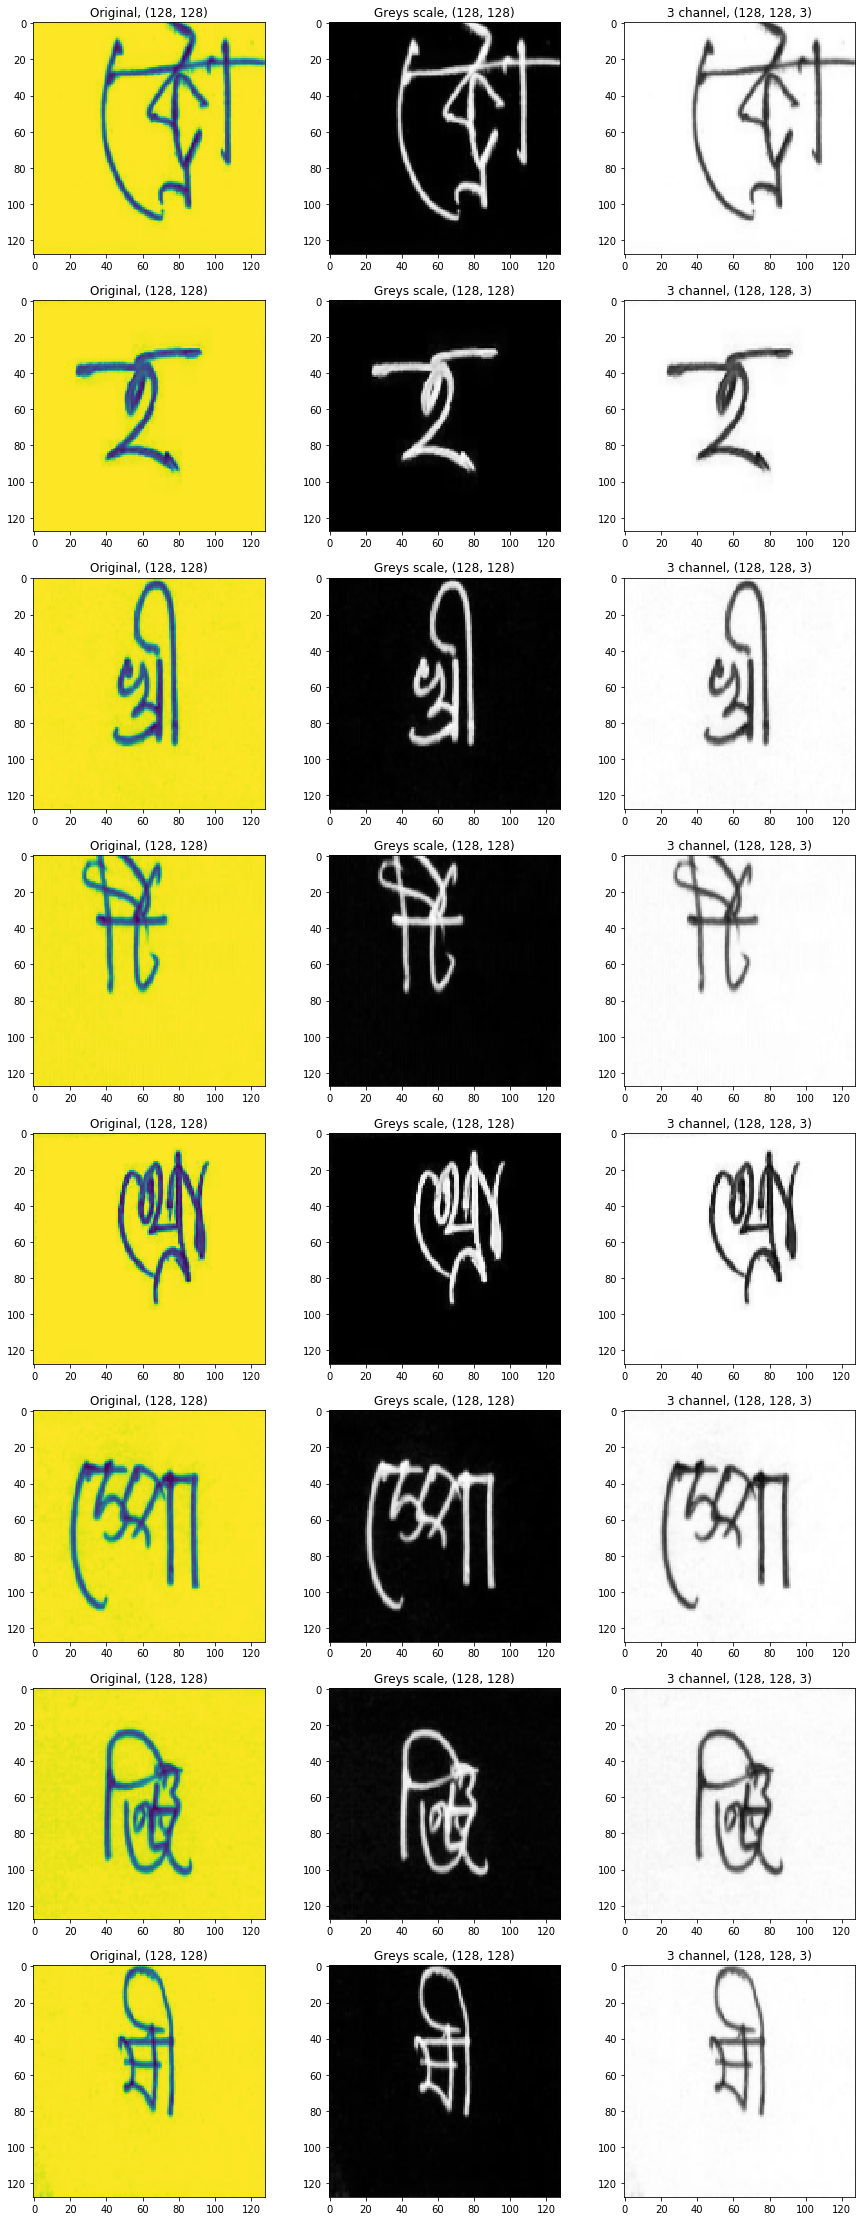

In [6]:
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 3, figsize=(15, 5*n_imgs))

for idx in range(n_imgs):
    img0 = df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    img0 = cv2.resize(img0, (IMG_SIZE,IMG_SIZE))

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title(f'Original, {img0.shape}')
    
    axs[idx,1].imshow(img0, cmap='Greys')
    axs[idx,1].set_title(f'Greys scale, {img0.shape}')
    
    img1 = np.stack((img0, img0, img0), axis=-1)
    axs[idx,2].imshow(img1)
    axs[idx,2].set_title(f'3 channel, {img1.shape}')    
plt.show()

In [7]:
def process(df):
    x_tot,x2_tot = [],[]
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        img0 = df.loc[df.index[i]].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
        img0 = cv2.resize(img0, (IMG_SIZE,IMG_SIZE))
        x_tot.append((img0/255.0).mean())
        x2_tot.append(((img0/255.0)**2).mean()) 
        resized[df.index[i]] = img0.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized, x_tot, x2_tot

In [8]:
x_tot,x2_tot = [],[]
for i, fname in enumerate(TRAIN):
    df = pd.read_parquet(fname)
    df, tmp_tot, tmp2_tot = process(df)
    x_tot.append(tmp_tot)
    x2_tot.append(tmp2_tot)
    df.to_feather(f'../input/train_image_data_{i}_{IMG_SIZE}_{IMG_SIZE}.feather')
    del df

In [9]:
#image stats
img_avr =  np.array(x_tot).mean()
img_std =  np.sqrt(np.array(x2_tot).mean() - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

mean: 0.9467122096605639 , std: 0.16302944502363986
